#  Fraud Detection Project
This notebook includes:
- Data loading
- Preprocessing with ColumnTransformer & OneHotEncoder
- Pipelines for Logistic Regression and Random Forest
- Model training and evaluation with classification report & ROC-AUC


In [9]:

# ===== 1. Imports =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score


In [10]:

# ===== 2. Load Data =====
# Change this path to your dataset path
DATA_PATH = "Fraud.csv"  

dataset = pd.read_csv(DATA_PATH)

df=dataset.copy()
print("Shape:", df.shape)
df.head()


Shape: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [11]:
df = df.sample(frac=0.2, random_state=42)  # 10% = ~600k rows

print("Shape:", df.shape)

Shape: (1272524, 11)


In [12]:

# ===== 3. Select Features & Target =====
X = df[['step','type','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']]
y = df['isFraud']

print("Features:", X.columns.tolist())
print("Target distribution:\n", y.value_counts(normalize=True))


Features: ['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
Target distribution:
 isFraud
0    0.998727
1    0.001273
Name: proportion, dtype: float64


In [18]:

# ===== 4. Train/Test Split =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train size:", X_train.shape, "Test size:", X_test.shape)

print("Fraud ratio in full data:", y.mean())
print("Fraud ratio in train:", y_train.mean())
print("Fraud ratio in test:", y_test.mean())


Train size: (1018019, 7) Test size: (254505, 7)
Fraud ratio in full data: 0.0012730604688005885
Fraud ratio in train: 0.0012730607189060323
Fraud ratio in test: 0.001273059468379796


In [19]:

# ===== 5. Preprocessing =====
categorical_cols = ['type']
numeric_cols = [c for c in X.columns if c not in categorical_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_cols),
        ('num', StandardScaler(), numeric_cols)
    ]
)


In [20]:

# ===== 6. Pipelines =====
log_reg_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

rf_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=20,
        max_depth=10,
        max_features="sqrt",
        n_jobs=-1,
        class_weight='balanced',
        random_state=42
    ))
])




===== Logistic Regression =====
              precision    recall  f1-score   support

           0     0.9999    0.9503    0.9745    254181
           1     0.0235    0.9383    0.0458       324

    accuracy                         0.9503    254505
   macro avg     0.5117    0.9443    0.5102    254505
weighted avg     0.9987    0.9503    0.9733    254505

ROC-AUC: 0.9893627370910619

===== Random Forest =====
              precision    recall  f1-score   support

           0     0.9999    0.9900    0.9950    254181
           1     0.1083    0.9506    0.1945       324

    accuracy                         0.9900    254505
   macro avg     0.5541    0.9703    0.5947    254505
weighted avg     0.9988    0.9900    0.9939    254505

ROC-AUC: 0.9939325886710166


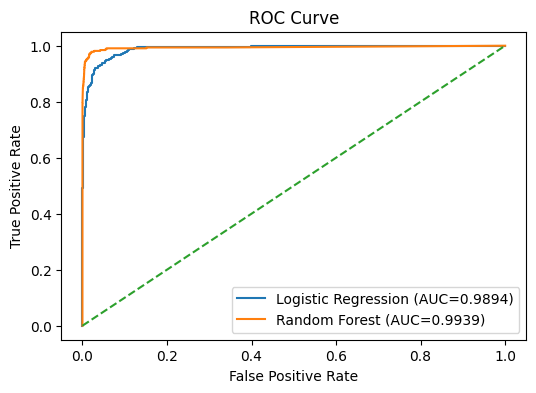

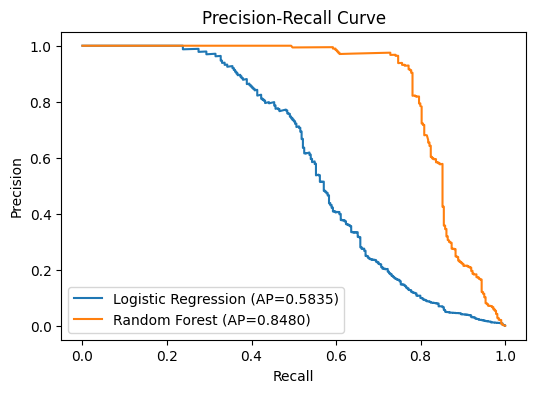

In [21]:

# ===== 7. Train & Evaluate =====
results = {}
for name, model in [("Logistic Regression", log_reg_pipeline),
                    ("Random Forest", rf_pipeline)]:
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:,1]

    print(f"\n===== {name} =====")
    print(classification_report(y_test, preds, digits=4))
    print("ROC-AUC:", roc_auc_score(y_test, probs))
    results[name] = (preds, probs)

# Plot ROC curves
plt.figure(figsize=(6,4))
for name, (_, probs) in results.items():
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, probs):.4f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve"); plt.legend(); plt.show()

# Plot Precision-Recall curves
plt.figure(figsize=(6,4))
for name, (_, probs) in results.items():
    prec, rec, _ = precision_recall_curve(y_test, probs)
    plt.plot(rec, prec, label=f"{name} (AP={average_precision_score(y_test, probs):.4f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall Curve"); plt.legend(); plt.show()
 